<a href="https://colab.research.google.com/github/m-hironori/PRML/blob/master/1_%E3%83%A2%E3%83%87%E3%83%AB%E4%BD%9C%E6%88%90%E3%81%AE%E5%9F%BA%E6%9C%AC(MNIST%E3%83%87%E3%83%BC%E3%82%BF%E3%81%A7%E6%89%8B%E6%9B%B8%E3%81%8D%E6%96%87%E5%AD%97%E8%AA%8D%E8%AD%98).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import keras
keras.__version__

Using TensorFlow backend.


'2.2.5'

# モデル作成の基本(MNISTデータで手書き文字認識)

MNIST手書き文字認識を解いてみましょう。

## 問題設定
手書き数字画像(0-9)を入力に、何の数字かを当てる。

項目 | 内容
--- | ---
入力データ形式 | 手書きの数字(0-9)画像。28 * 28 の白黒。
予測すること | 0 - 9 のどれが書いてあるか。多クラス分類問題。 
評価指標 | accuracy
評価方法 | ホールドアウト(訓練 60,000, テスト10,000)
 

## データ準備

kerasにデータセットが用意されているので、これをロードする。

In [0]:
from keras.datasets import mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

### データ量と内容を確認

In [3]:
import numpy as np

print(f"学習用データ {train_images.shape}, {train_images.dtype}")
print(f"学習用ラベル {train_labels.shape}, {train_labels.dtype}")
print(f"テストデータ {test_images.shape}, {test_images.dtype}")
print(f"テストラベル {test_labels.shape}, {test_labels.dtype}")

学習用データ (60000, 28, 28), uint8
学習用ラベル (60000,), uint8
テストデータ (10000, 28, 28), uint8
テストラベル (10000,), uint8


学習用データ60,000件、テスト用データ10,000件あることがわかる。
データ内容は整数型である。

次に、データとラベルの内容を見てみる。

In [4]:
print(f"学習データ max {np.max(train_images)}, min {np.min(train_images)}")
print(f"テストデータ max {np.max(test_images)}, min {np.min(test_images)} ")
print(f"学習ラベル max {np.max(train_labels)}, min {np.min(train_labels)}")
print(f"学習ラベル uniq {np.unique(train_labels)}")
print(f"テストラベル max {np.max(test_labels)}, min {np.min(test_labels)} ")
print(f"テストラベル uniq {np.unique(test_labels)}")

学習データ max 255, min 0
テストデータ max 255, min 0 
学習ラベル max 9, min 0
学習ラベル uniq [0 1 2 3 4 5 6 7 8 9]
テストラベル max 9, min 0 
テストラベル uniq [0 1 2 3 4 5 6 7 8 9]


データは、画像の1チャネルデータで 0 - 255 の値。

ラベルは、0 - 9 の数値で、学習用にもテスト用にも欠損しているラベルはない。

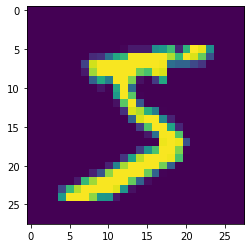

In [5]:
import matplotlib.pyplot as plt
plt.imshow(train_images[0])
plt.show()

In [6]:
train_labels[0]

5

## ベースライン指標(統計的検出力(statistical power))

ラベルごとの頻度を見てみる。

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

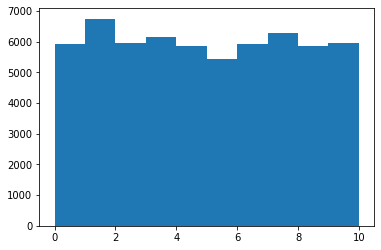

In [7]:
plt.hist(train_labels, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

(array([ 980., 1135., 1032., 1010.,  982.,  892.,  958., 1028.,  974.,
        1009.]),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
 <a list of 10 Patch objects>)

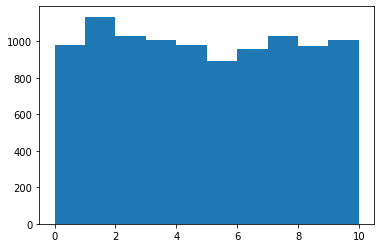

In [8]:
plt.hist(test_labels, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

"5"が少し少ない気もするが、大体均等であることがわかる。

ラベルに偏りはないので、accurayを指標にして大丈夫そうである。

0 - 9 を当てる問題であり、かつ、ラベル頻度も均等なので、
**accuracy 0.1**
が統計的検出力となる。




## モデル開発

### まずは統計的検出力を上回る**モデルを作成**する。

あまり凝ったことはせず、単純なモデルを試す。

In [9]:
from keras import models
from keras import layers

network = models.Sequential()
network.add(layers.Dense(512, activation='relu', input_shape=(28 * 28,)))
network.add(layers.Dense(10, activation='softmax'))

* ニューラルネットワークのコアブロックは **レイヤ**。
  * レイヤは特定のフィルタリングを行うデータ処理モジュール
  * 複数のレイヤを通過することで、問題を解くのに最適なデータの表現(representations)が出力される。
  * Deep Learningでは、複数の単純なレイヤを組み合わせることで、データ蒸留(data distillation)していく。
* 今回のモデルは単純な`Dense`レイヤ
  * 全結合層(fully-connected layer)ともいわれる
  * 最初に512個の要素をもつベクトルに表現を変える。
  * 最初のレイヤは、`input_shape`引数を指定して、入力データのテンソル形状をネットワークに教える必要がある。今回は、28 x 28 で画像の全体を1次元ベクトルにした形状。
  * 最後に 10個のクラスに分割するための `softmax` レイヤを追加する。これによって10個の別々の数字のどれかに正しそうか確率が出てくる。







### 次に、ネットワークを作るために **コンパイル** する


In [10]:
network.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

* loss関数：学習データの中で真の値とシステム出力の差を計算し、これを近づける方向を示す関数
* optimizer関数：loss関数とデータを使ってどの程度パラメタを変更すべきかを決める最適化関数
* metrics：学習データやテストデータをモニタリングする指標。今回の場合 *accuracy*。

### 次にデータを、このネットワークに合うように**データ前処理**する。
* データ
  * 形状を 28 x 28 の画像を、フラットにする
  * うまく学習できるように、画素の値`[0, 255]`を、`[0, 1]`にスケーリングする
* ラベル
  * `[0 - 9]`の数値を、onehotベクトルに変換する
  * one hot ベクトルとは、カテゴリデータを示すためによく使われるベクトル。今回は、10個の要素を持つベクトルに変換する。

In [0]:
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype('float32') / 255

test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype('float32') / 255

In [0]:
from keras.utils import to_categorical

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

In [13]:
train_labels[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

`5`を示す要素の位置に`1`となる要素10個のベクトルになっている。

学習データは、訓練データ(training)と検証データ(valitation)に分ける。

今回の場合、60,000件の学習データがあるので、その10%程度6,000件を検証データに使いたい。

kerasでは、学習時に、学習データの指定した割合のデータを検証用データとして選択する機能があるので、これを使う。ただし、学習データをランダムに選択はせず、学習データリストの最後の指定割合が使われるので、学習データをランダムに並べかをを行っておく。


In [0]:
indices = np.arange(train_images.shape[0])
np.random.shuffle(indices)
train_images = train_images[indices]
train_labels = train_labels[indices]

### 次に**学習**する。

`fit`メソッドを呼ぶ。

In [15]:
history = network.fit(train_images, train_labels, validation_split=0.1, epochs=10, batch_size=128)


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 54000 samples, validate on 6000 samples
Epoch 1/10





54000/54000 [==============================] - 5s 87us/step - loss: 0.2695 - acc: 0.9220 - val_loss: 0.1604 - val_acc: 0.9537
Epoch 2/10
54000/54000 [==============================] - 5s 84us/step - loss: 0.1125 - acc: 0.9665 - val_loss: 0.1208 - val_acc: 0.9642
Epoch 3/10
54000/54000 [==============================] - 4s 82us/step - loss: 0.0738 - acc: 0.9777 - val_loss: 0.0964 - val_acc: 0.9708
Epoch 4/10
54000/54000 [==============================] - 5s 83us/step - loss: 0.0539 - acc: 0.9835 - val_loss: 0.0863 - val_acc: 0.9735
Epoch 5/10
54000/54000 [==============================] - 4s 83us/step - loss: 0.0408 - acc: 0.9877 - val_loss: 0.0881 - val_acc: 0.9743
Epoch 6/10
54000/54000 [==============================] - 5s 86us/step - loss: 0.0303 - acc: 0.9911 - val_loss: 0.0968 - val_acc: 0.9750
Epoch 7/10
54000/54000 [===

損失値と正解率をプロットする

In [16]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

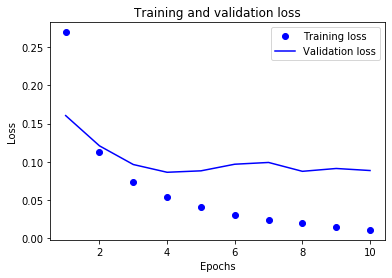

In [17]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

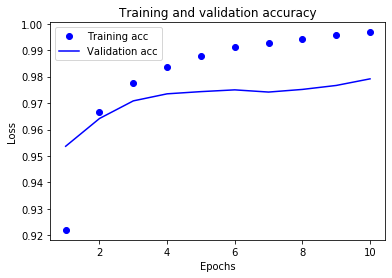

In [18]:
plt.clf()
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## 評価

テストデータで、今回の評価指標である accuracy を計測する

In [19]:
test_loss, test_acc = network.evaluate(test_images, test_labels)

10000/10000 [==============================] - 1s 53us/step


In [20]:
print('test_acc:', test_acc)

test_acc: 0.9805


98.1% の正解率であり、統計的検出ラインを上回ったので、まずは合格。

## チューニング

今回のモデルはかなり単純なモデルだった。もう少し複雑なモデルでもよいかもしれない。

複雑なモデルの作成は、別の章で行う。